In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

import numpy as np
from tqdm.notebook import tqdm
import torch

# import minimax scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from response.maps import  collect_posterior_means
from deep_traffic_generation.cvae import CVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from traffic.core import Traffic

# add automatic reloading of modules
%load_ext autoreload
%autoreload 2

device = "cpu"

# seed everything
np.random.seed(32)
torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Loading data and model

In [4]:
dataset_name = "zurich_2019_flyover"
dataset = TrafficDataset.from_file(
        f"data/aircraft_flyover/{dataset_name}.parquet",
        features=["longitude", "latitude"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        shape= "image",
        info_params={"features": ["latitude", "longitude"], "index": -1},
    )

In [ ]:
model_path = r'C:\Users\Zak\Desktop\code\ExplainAutoencoder\models\aircraft.ckpt'

model = CVAE.load_from_checkpoint(model_path, dataset_params=dataset.parameters).to(device)

Collect posterior means

In [ ]:
# Collect posterior samples for the histogram
batch_size = 512
Z = collect_posterior_means(model, dataset, device=device, batch_size=batch_size, pbar=tqdm).detach().cpu()

  0%|          | 0/1183 [00:00<?, ?it/s]

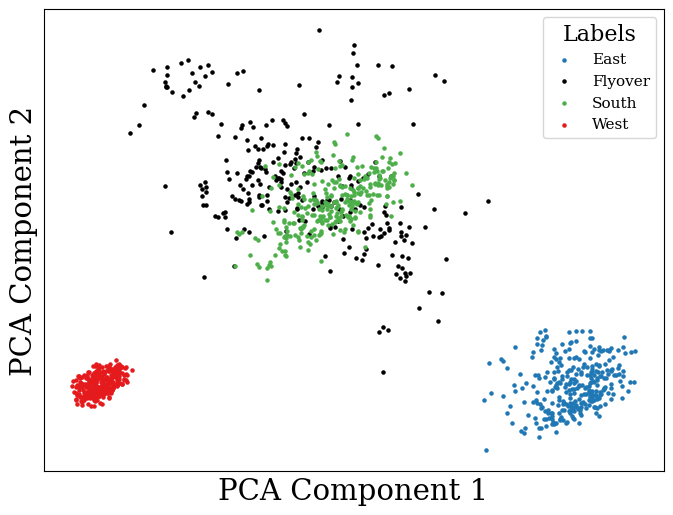

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fix = 10
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 16,               # Base font size
    "axes.titlesize": 12+fix,          # Titles slightly larger
    "axes.labelsize": 11+fix,          # Axis labels size
    "xtick.labelsize": 11+fix,         # Tick labels size
    "ytick.labelsize": 11+fix,
    "legend.fontsize": 11,
})

# Assuming 'Z' and 'dataset.labels' are already available in the environment.
# Convert the labels to a numpy array of strings to ensure proper mapping.
labels = np.array(dataset.labels, dtype=str)


# Check if labels length matches the number of data points in Z; subset if necessary.
if len(labels) != Z.shape[0]:
    labels = labels[:Z.shape[0]]

# Performing PCA on Z.
pca = PCA(n_components=2).fit(Z[labels!='Flyover'])
Z_pca = pca.transform(Z)

# Define a consistent color mapping for labels.
color_map = {
    'Flyover': '#000000',
    'East': '#1f77b4',
    'West': '#e41a1c',
    'South': '#4daf4a',
}

# Plotting the PCA results with the proper color for each string label.
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
for label in unique_labels:
    # Get indices where the current label matches.
    idx = np.where(labels == label)
    # Get the corresponding color or default to black.
    color = color_map.get(label, '#000000')
    plt.scatter(Z_pca[idx, 0], Z_pca[idx, 1], label=label, color=color, alpha=1, s=5)

# Configure plot labels and remove grid and axis numbers.
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.legend(title="Labels")
plt.savefig("figures/flyover/untrained/pca.pdf")
plt.show()
